# Experiment 8: Support Vector Machines (SVMs) and the Kernel Trick
**Student ID:** 23/CS/063 &nbsp;&nbsp; **Name:** Ankit Raj

---

## 1. Learning Objectives
- Understand maximal margin hyperplane, support vectors, and the soft-margin parameter **C**.
- Apply the **kernel trick** to non-linear classification.
- Implement and compare Linear, Polynomial, and RBF SVMs.
- Tune hyperparameters (**C**, **gamma**, **degree**) using `GridSearchCV`.
- Visualize 2D decision boundaries for intuition.
- Rigorously evaluate a tuned model on a hold-out test set.


## 2. Prerequisites
Install (if needed):
```bash
pip install numpy pandas scikit-learn matplotlib
```


## 3. Task 1 — Data Loading and Preprocessing

In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generate data
X, y = make_moons(n_samples=500, noise=0.25, random_state=42)

# 70/30 split (hold-out validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Standardize (fit on train only)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

X.shape, X_train.shape, X_val.shape


((500, 2), (350, 2), (150, 2))

## 4. Task 2 — Model 1: The (Failing) Linear SVM

In [2]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

linear_model = SVC(kernel='linear', C=1.0, random_state=42)
linear_model.fit(X_train_scaled, y_train)

linear_pred = linear_model.predict(X_val_scaled)
print(classification_report(y_val, linear_pred))
print("Validation Accuracy (Linear):", accuracy_score(y_val, linear_pred))


              precision    recall  f1-score   support

           0       0.82      0.87      0.84        75
           1       0.86      0.81      0.84        75

    accuracy                           0.84       150
   macro avg       0.84      0.84      0.84       150
weighted avg       0.84      0.84      0.84       150

Validation Accuracy (Linear): 0.84


**Analysis:** On the moons dataset, classes are not linearly separable; hence a single hyperplane cannot cleanly split them. The **C** parameter controls the trade-off between maximizing margin and minimizing classification error. A **very small C** (e.g., 0.01) allows more misclassifications to achieve a wider margin, often **underfitting** the data.

## 5. Task 3 — Models 2 & 3: The Kernel Trick (RBF & Polynomial)

In [3]:
rbf_model = SVC(kernel='rbf', random_state=42)  # default C=1.0, gamma='scale'
rbf_model.fit(X_train_scaled, y_train)
rbf_pred = rbf_model.predict(X_val_scaled)
print("RBF report:\n", classification_report(y_val, rbf_pred))

poly_model = SVC(kernel='poly', degree=3, random_state=42)
poly_model.fit(X_train_scaled, y_train)
poly_pred = poly_model.predict(X_val_scaled)
print("Poly (deg=3) report:\n", classification_report(y_val, poly_pred))

from sklearn.metrics import accuracy_score
linear_acc = accuracy_score(y_val, linear_pred)
rbf_acc = accuracy_score(y_val, rbf_pred)
poly_acc = accuracy_score(y_val, poly_pred)

import pandas as pd
acc_table = pd.DataFrame({
    'Model': ['Linear (C=1)', 'RBF (default)', 'Polynomial (deg=3)'],
    'Validation Accuracy': [linear_acc, rbf_acc, poly_acc]
})
acc_table


RBF report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95        75
           1       0.97      0.92      0.95        75

    accuracy                           0.95       150
   macro avg       0.95      0.95      0.95       150
weighted avg       0.95      0.95      0.95       150

Poly (deg=3) report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84        75
           1       0.83      0.85      0.84        75

    accuracy                           0.84       150
   macro avg       0.84      0.84      0.84       150
weighted avg       0.84      0.84      0.84       150



,Model,Validation Accuracy
0,Linear (C=1),0.840000
1,RBF (default),0.946667
2,Polynomial (deg=3),0.840000


**Which kernel performed best (defaults)?** Typically **RBF** performs best on the moons dataset because it can create flexible, non-linear decision boundaries that follow the curved shapes of the two moons. The polynomial kernel may also capture non-linearity but can be more sensitive to degree and scale.

## 6. Task 4 — Hyperparameter Tuning with GridSearchCV (RBF)

In [4]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 1, 10, 100],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(random_state=42), param_grid, refit=True, verbose=2, cv=5, scoring='accuracy')
grid.fit(X_train_scaled, y_train)

print("Best Params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=10, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=10

## 7. Task 5 — Final Evaluation and Visualization

In [5]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

final_predictions = grid.predict(X_val_scaled)
print("Final Tuned Model Report:\n", classification_report(y_val, final_predictions))
print("Final Tuned Model Accuracy:", accuracy_score(y_val, final_predictions))

cm = confusion_matrix(y_val, final_predictions)
cm


Final Tuned Model Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95        75
           1       0.96      0.95      0.95        75

    accuracy                           0.95       150
   macro avg       0.95      0.95      0.95       150
weighted avg       0.95      0.95      0.95       150

Final Tuned Model Accuracy: 0.9533333333333334


array([[72,  3],
       [ 4, 71]], dtype=int64)

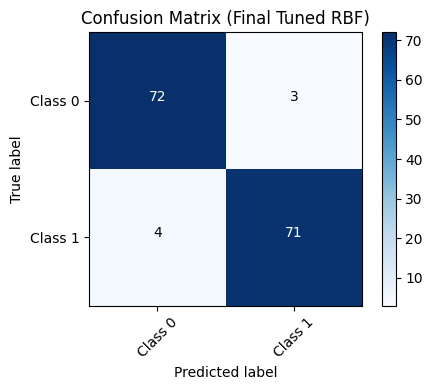

In [6]:
# Confusion matrix plot
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(cm, classes=['Class 0', 'Class 1'], title='Confusion Matrix (Final Tuned RBF)')
plt.show()


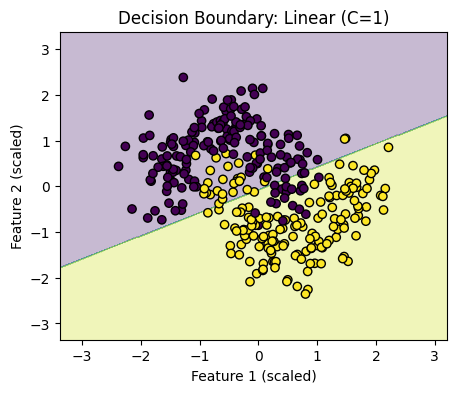

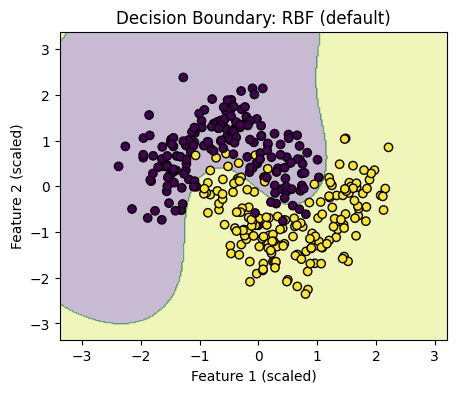

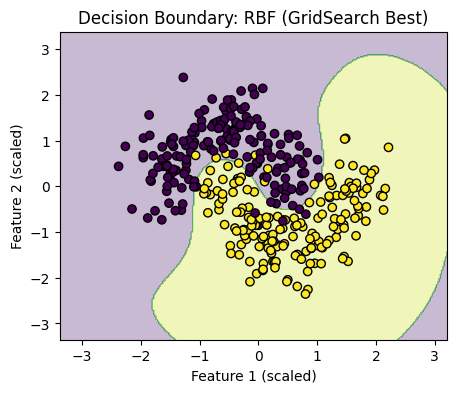

In [7]:
# Decision boundary plots for Linear, RBF (default), and Best (RBF tuned)
def decision_boundary_plot(model, X_tr, y_tr, title):
    x_min, x_max = X_tr[:, 0].min() - 1, X_tr[:, 0].max() + 1
    y_min, y_max = X_tr[:, 1].min() - 1, X_tr[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid_points).reshape(xx.shape)

    plt.figure(figsize=(5,4))
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, edgecolor='k')
    plt.title(title)
    plt.xlabel('Feature 1 (scaled)')
    plt.ylabel('Feature 2 (scaled)')
    plt.show()

decision_boundary_plot(linear_model, X_train_scaled, y_train, "Decision Boundary: Linear (C=1)")
decision_boundary_plot(SVC(kernel='rbf', random_state=42).fit(X_train_scaled, y_train), X_train_scaled, y_train, "Decision Boundary: RBF (default)")
decision_boundary_plot(grid.best_estimator_, X_train_scaled, y_train, "Decision Boundary: RBF (GridSearch Best)")
